In [31]:

import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.python.eager'

In [6]:
df = pd.read_hdf('./data/merged_data.h5')


In [9]:
timestamp_s = df.time

In [10]:
hour = 60
day = 60 * 24

df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [11]:
df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,Hour sin,Hour cos,Day sin,Day cos
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755,0.000000,1.000000,0.000000,1.000000
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188,0.104528,0.994522,0.004363,0.999990
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459,0.207912,0.978148,0.008727,0.999962
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000,0.309017,0.951057,0.013090,0.999914
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534,0.406737,0.913545,0.017452,0.999848


Text(0.5, 1.0, 'Time of day signal')

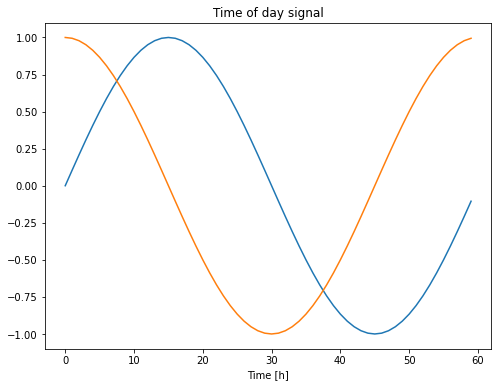

In [20]:
plt.plot(np.array(df['Hour sin'])[:60])
plt.plot(np.array(df['Hour cos'])[:60])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [23]:
tf.signal.rfft

AttributeError: module 'tensorflow' has no attribute 'signal'

In [21]:
fft = tf.signal.rfft(df['open'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['open'])
hours_per_days = 60 * 24
days_per_dataset = n_samples_h/(hours_per_days)

f_per_days = f_per_dataset/days_per_dataset
plt.step(f_per_days, np.abs(fft))
plt.xscale('log')
plt.ylim(-2, 2)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

AttributeError: module 'tensorflow' has no attribute 'signal'

In [30]:
tf.__spec__

ModuleSpec(name='tensorflow', loader=<_frozen_importlib_external._NamespaceLoader object at 0x000001893F4C20C8>, submodule_search_locations=_NamespacePath(['C:\\Anaconda3\\envs\\venv\\lib\\site-packages\\tensorflow']))

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [91]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [92]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
    
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])



In [93]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['open'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']

In [94]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [95]:
WindowGenerator.split_window = split_window

In [96]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [98]:
w2.example = example_inputs, example_labels

In [99]:
def plot(self, model=None, plot_col='open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [116]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [114]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [115]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

AttributeError: module 'tensorflow.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'

In [113]:
!pip install 

1.10.0
